In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

### Step 1: Download the data.

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


#### Read the data into a list of strings.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))  # Johnny: it means 17005207 words in text8

Data size 17005207


In [4]:
collections.Counter(vocabulary).most_common(5)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201)]

### Step 2: Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary) # finally, dictionary = {'UNK':0, 'the':1, 'of':2 ....}
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count # count[0] is ['UNK', -1], so count[0][1] records unk_count replacing -1
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3084, 12, 6, 195, 2, 3136, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
print(len(data))
jjj = np.ndarray(shape=(3), dtype=np.int32)
print(jjj)
jjj = collections.deque(maxlen=3)
jjj.append(1)
jjj.append(2)
jjj.append(3)
jjj.append(4)
print(jjj)
np.random.choice(100, 16, replace=False)

17005207
[988924792     32553 988924792]
deque([2, 3, 4], maxlen=3)


array([ 2, 42, 27, 96, 52, 58,  7, 64, 28, 15, 78, 67, 46, 74, 11, 81])

### Step 3: Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0     # raise-if-not
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32) # ndarray : The N-dimensional array
  # Johnny, batch.fill(0)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  # Johnny, labels.fill(0)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ], span = 2 * 1 + 1 = 3
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # len(data) is 17005207
  #Johnny, print(buffer) # [5238, 3084, 12]
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer : [ skip_window target skip_window]
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)     # random.randint(0, 2), target is 0, 1, or 2. Why did random?
      targets_to_avoid.append(target)
      #Johnny, print(targets_to_avoid) # [1, 0] or [1, 2] => [1, 0, 2] or [1, 2, 0]
      batch[i * num_skips + j] = buffer[skip_window]  # target label at the center of the buffer. so batch records target label?
      #Johnny, print(batch)
      labels[i * num_skips + j, 0] = buffer[target]  # target variable shows the left and right (randomly) words of target
      #Johnny, print(labels) 
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    #Johnny, print(buffer)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print(batch)
print(labels)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

[3084 3084   12   12    6    6  195  195]
[[5242]
 [  12]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   6]
 [   2]]
3084 originated -> 5242 anarchism
3084 originated -> 12 as
12 as -> 3084 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


### Step 4: Build and train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

We pick a random validation set to sample nearest neighbors.<br>
Here we limit the validation samples to the words that have a low numeric ID,<br>
which by construction are also the most frequent.

In [9]:
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

print(valid_examples)

[73 97 17 79 60 91 92 70 25 87  5  6 98 94 62 71]


In [10]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()


### Step 5: Begin training.

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0: #Johnny, origianl is % 10000
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  255.957168579
Nearest to b: stoney, nut, bas, ranging, celery, astrobiology, cronus, exits,
Nearest to will: wcw, quarterfinals, uriah, harbored, wander, churchland, frisbee, oswaldo,
Nearest to three: sen, ribeira, intercity, supra, quijote, grumman, cite, linked,
Nearest to about: adage, exchange, rodrigo, crops, bernardi, bankers, musique, coordinate,
Nearest to there: mirabeau, cady, mutant, harbour, ecclesia, pala, musk, hermetic,
Nearest to th: insubordination, danneskj, purchases, low, edit, acosta, rubble, profess,
Nearest to system: imr, osaka, bmw, airtime, triumphs, appalachia, pashtun, onager,
Nearest to than: necessity, fraud, sexism, steadfastly, ballpark, aasen, verb, nolan,
Nearest to on: mithra, strive, nasr, sub, thx, mobilize, virtual, heights,
Nearest to known: pacific, ic, gime, heracleidae, buffers, fertilisation, sevilla, overcrowding,
Nearest to in: megafauna, optimize, iwerks, quod, kops, stv, bilge, christianum,
Nearest t

Average loss at step  82000 :  4.75440512168
Average loss at step  84000 :  4.75458835495
Average loss at step  86000 :  4.77041121483
Average loss at step  88000 :  4.74126074755
Average loss at step  90000 :  4.72019044912
Average loss at step  92000 :  4.68290424967
Average loss at step  94000 :  4.72264732254
Average loss at step  96000 :  4.69411774015
Average loss at step  98000 :  4.60547295022
Average loss at step  100000 :  4.69175478494
Nearest to b: d, cronus, aba, six, microcebus, cebus, benzene, UNK,
Nearest to will: would, can, may, could, might, must, should, cumbersome,
Nearest to three: four, five, two, seven, six, eight, agouti, nine,
Nearest to about: four, adage, microcebus, march, memory, over, neopaganism, three,
Nearest to there: it, they, now, he, often, she, agouti, not,
Nearest to th: nine, seven, insubordination, sepulchre, crb, six, four, eight,
Nearest to system: systems, hellene, wheels, yorker, interfere, banshee, dasyprocta, cebus,
Nearest to than: or, a

### Step 6: Visualize the embeddings.

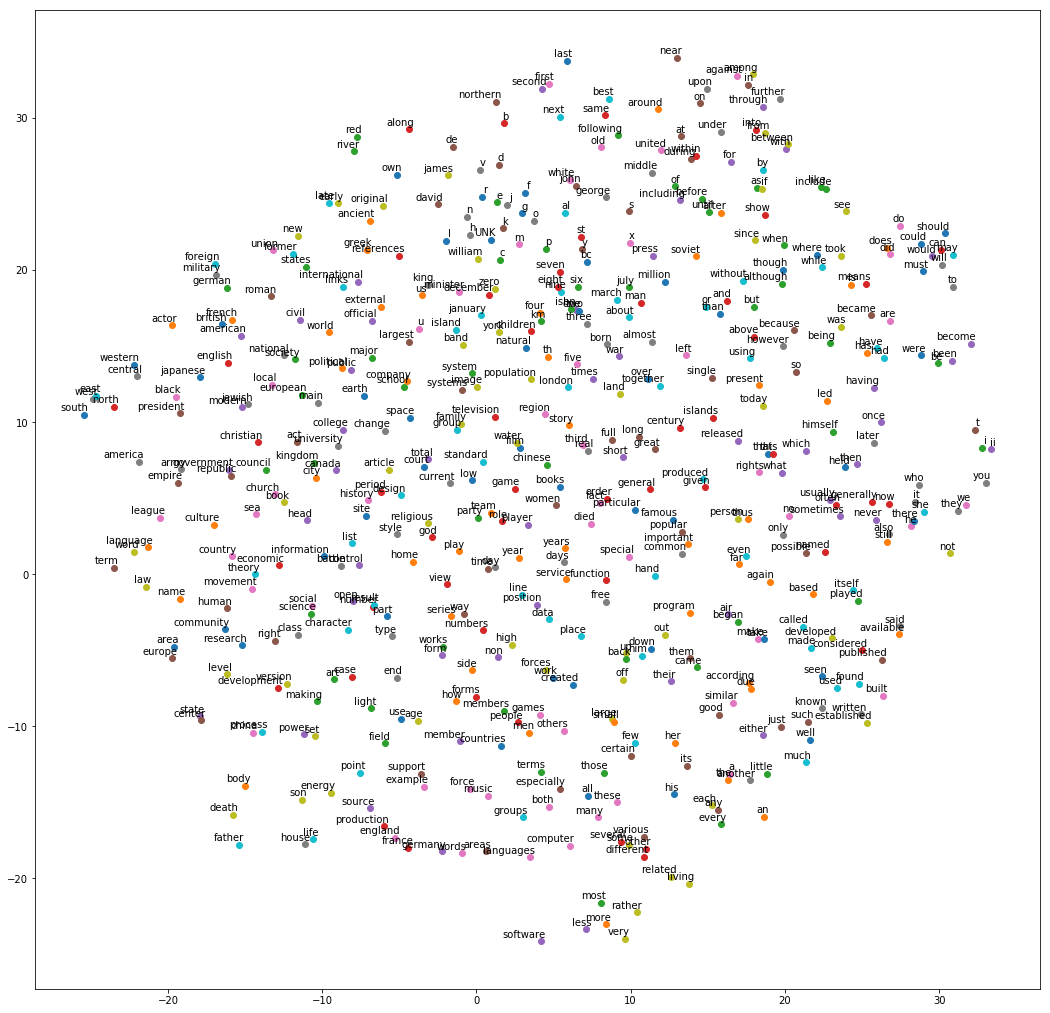

In [12]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)
  plt.show()

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')